# Class 15: Graph Machine Learning 2

## Goals of today's class:
1. Understand what embeddings are and how neural networks work at a high level.
2. Explain what makes graph neural networks different from other kinds of neural networks (i.e. how do they learn on network data?)
3. Iterate on an example neural network model to learn about what affects its performance.

## Embeddings and Neural Networks

TL;DR: We often represent our data as vectors, but these vectors can get really, really long. They also tend to be sparse. By learning **embeddings** that more concisely represent our data, we can learn more meaningful patterns in our data.

### Embeddings
When we talk about making **embeddings**, we're talking about representing our data points or objects in our dataset as meaningful vectors. In graphs, and in natural language, we *could* represent nodes and words as sparse vectors. These might look like the sparse rows in an adjacency matrix, or they might look like one-hot representations whose length is equal to the cardinality of a language's entire vocabulary. Of course, representations like these aren't very useful when we think about looking at questions of similarity or really any sort of machine learning applications. 

Enter **embeddings**. Embeddings can result from dimensionality reduction techniques like principal component analysis (PCA), but nowadays, when we think about embeddings, we tend to think about vectors that are created via training a neural network model to do a task. 

### Neural Networks
(this section borrows heavily from the coverage of ML in Bagrow & Ahn, section 16.2)

These can seem complicated to understand, but they, are at their heart, just doing a bunch of very parallelizable matrix operations. Here's a picture of a simple **feed-forward** neural network, sourced from this handy [Medium post](https://medium.com/analytics-vidhya/in-depth-explanation-of-feedforward-in-neural-network-mathematically-448092216b63). 

![feed-forward NN](https://miro.medium.com/v2/resize:fit:3200/1*ycDUAMaxDYaHx7xl9pqEjg.png)

Neural networks consist of sets of units (neurons) arranged in a sequence of layers. When we talk about the **architecture** of a neural network, we're talking about how the units are arranged, how many of them there are, how many layers we have, and the number of units per layer. In a fully connected feed-forward network, each unit in each layer is connected to all the nodes in the layer after it. First, the input nodes (the green ones) receive the input data (this could be attributes of a product, for example). Data moves through the network in the picture from left to right. 

The output of a particular unit is the activation function of the weighted sum of its inputs ($\sigma(\vec{w}^T \vec{x})$), where $\vec{w}$ is the weights of the inputs for that unit, and $\vec{x}$ is the inputs coming from the previous layer. $\sigma$ is the nonlinear activation function; in this case, we're probably thinking of the sigmoid function (pictured below & sourced [here](https://groups.csail.mit.edu/medg/hamish/medcomp3/sld007.htm)), but other activation functions, like $\tanh$, are possible as well (image sourced [here](https://sebastianraschka.com/faq/docs/activation-functions.html)).

![sigmoid](https://groups.csail.mit.edu/medg/hamish/medcomp3/img007.gif)

Neural networks can learn nonlinear patterns in data because of these nonlinear activation functions. If they only used linear activation functions, they would be learning the weights for a weighted piecewise linear function on their inputs. In other words, neural networks are powerful precisely because they have many built-in nonlinearities.

![activations](https://sebastianraschka.com/images/faq/activation-functions/activation-functions.png)

The outputs we get from each unit in the middle layer then are passed to the final layer, and then we compare the final layer's output to our desired output. Maybe the $\vec{y}$ outputs in the picture are probabilities of the product belonging to a particular class, for example. Our task is to use a **loss function**, of which there are many, to express how far off we are from our correct answer. Once we've done that, we can use an algorithm called **backpropagation** to nudge the weights ($\vec{w}$) towards values that would be closer to producing the desired label. 

Our choice of loss function is important here; what works well for classifying products may be terrible for predicting flight prices, for example. For a more complete primer on loss functions, check out [this blog post](https://www.geeksforgeeks.org/loss-functions-in-deep-learning/). Generally, your loss function and the tasks you're setting up the neural network to learn will reflect what you want your neural network to do effectively. We might use a squared error loss function if we're predicting flight prices, and we might use a cross-entropy loss function to quantify how incorrect our predictions are for a classifier. There are more complicated loss functions and task setups, one of which we'll discuss in the next section. 

### \*tovec
#### Word2Vec
[Word2Vec](https://arxiv.org/pdf/1301.3781) was a pretty early natural language processing technique that was very exciting at the time. It trained a fairly simple neural network to do one of two tasks: Continuous Bag-of-Words (CBOW) or Skip-Gram. CBOW involves predicting which word is missing from a given context of surrounding words, and Skip-Gram involves doing the opposite: predicting the surrounding context given a specific word. The loss function here is cross-entropy loss; we use a softmax activation function to turn the outputs of the final layer into a probability distribution and then use cross-entropy loss to quantify how incorrect we were. Here's some more info; the links are where we sourced our images for [softmax](https://gombru.github.io/2018/05/23/cross_entropy_loss/) and [word2vec](https://devopedia.org/word2vec).

![word2vec tasks](https://devopedia.org/images/article/221/9279.1570465016.png)

![softmax + cross-entropy](https://gombru.github.io/assets/cross_entropy_loss/softmax_CE_pipeline.png) 


#### Node2Vec
[Node2Vec](https://arxiv.org/pdf/1607.00653) follows similar logic to Word2Vec. We do random walks through a network and treat these random walks like sentences. Then we can do CBOW or Skip-Gram to obtain node embeddings. At each iteration, Node2Vec samples $n * r$ random walks (with $r$ walks starting at each node). It has hyperparameters that influence how much we revisit nodes ($p$) and how much we favor visiting close nodes versus nodes that are further from where we started ($q$). 

When people around the time of Node2Vec were thinking about building node embeddings, they tended to consider homophily (nodes that are linked are likely to be similar) or structural equivalence (nodes with similarly structured neighborhoods are likely to be similar). Random walks that are closer to depth-first search tend to get further away from their start node, so they'll have a better sense of the community structure of a given graph and we'll get more information about node homophily (in theory). However, longer-range dependencies can be harder to make sense of and more complicated. If we instead do something more like a breadth-first search, we're thinking more about structural equivalence -- whose neighborhoods looks similar? This isn't likely to explore more distant parts of the graph, and nodes will repeat themselves a lot in a given walk. So Grover & Leskovec structured their random walks with hyperparameters $p$ and $q$ that allow us to figure out where on the BFS - DFS spectrum we want to end up. 

Our non-normalized probability $\alpha(v, x) * w(v, x)$ of visiting a given node $x$ after having visited $v$ in the previous step is:
$$
\alpha(v, x) = 
\begin{cases}
\frac{1}{p} & if d(v, x) = 0 \\
1 & if d(v, x) = 1 \\
\frac{1}{q} & if d(v, x) = 2
\end{cases}
$$

where $d(i, j)$ is the number of hops between node $i$ and node $j$. 

Here's an image from the original Node2Vec paper of the different outcomes of Node2Vec on a network generated from the novel *Les Misérables* with hyperparameter settings that lean more towards prioritizing homophily (closer to DFS) and structural equivalence (closer to BFS).

![lesmis](./images/les_mis_node2vec.png)

Node2Vec also incorporates **negative sampling**, where we only look at the outputs for a couple nodes that definitely **shouldn't** be in an input node's neighborhood. We make sure our outputs for those nodes are zero and do backpropagation accordingly; it's possible to tune how many negative samples we do for each positive sample. Adding negative samples improves our model's performance, and it's relatively cheap to do because we're not tuning all the weights in the model at once. 

We can do a version of Node2Vec where we're making embeddings for embeddings' sake, as we do in this setting, or we can try to train a classifier on Node2Vec embeddings to predict labels for nodes. Here we're going to train Node2Vec (without node or edge labels) on the Cambridge, MA road network dataset. Let's see what happens! Our training code is borrowed from `pytorch-geometric` and can be found [here](https://github.com/pyg-team/pytorch_geometric/blob/master/examples/node2vec.py).

Notice that since we're just trying to build embeddings to demonstrate Node2Vec's capabilities, we're not holding out any data right now. Node2Vec *does* sample negative examples as it trains, so that the model learns which contexts or nodes are correct and builds accurate embeddings. If we were training a link prediction model with Node2Vec, as you can choose to do at the end of this class, we would at minimum hold out some fraction of links to make sure our embeddings were of good quality and useful for the downstream link prediction task. 

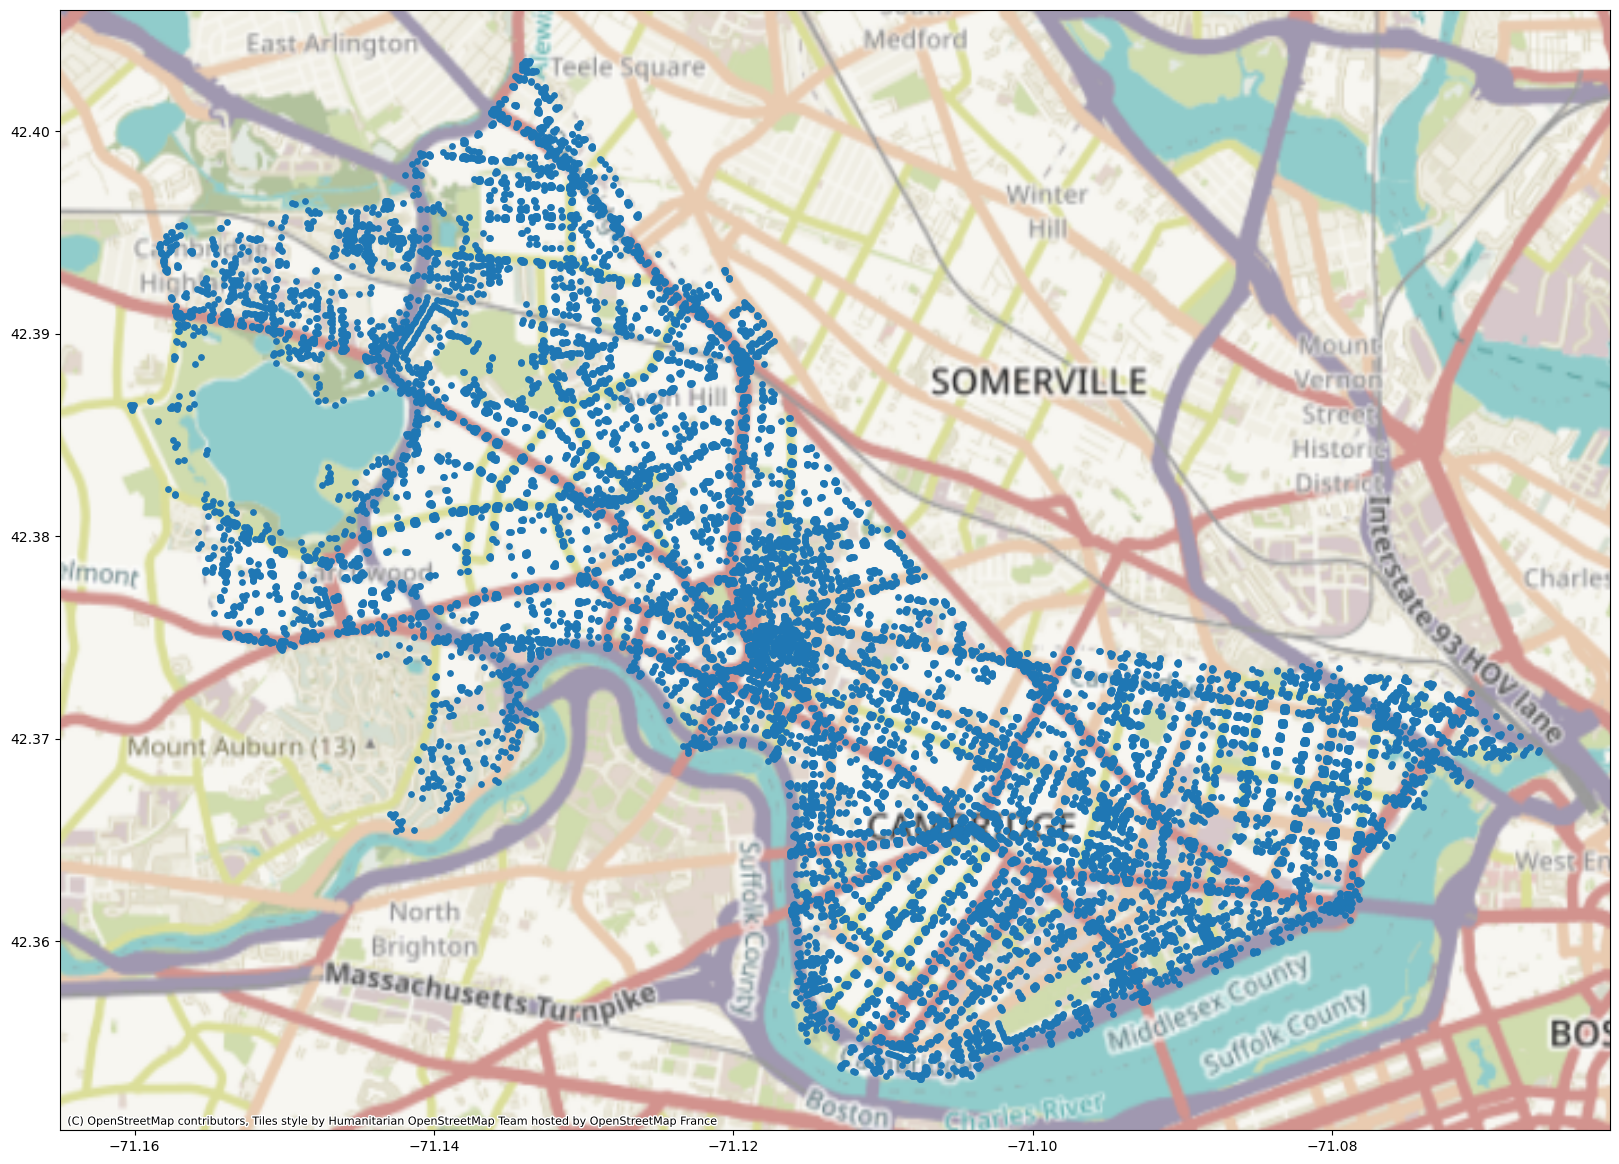

In [3]:
import osmnx as ox
from shapely import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx

plt.rcParams['figure.figsize'] = (20, 20)
S = 15

G = ox.graph_from_place('Cambridge, Massachusetts, United States')

points = [Point((G.nodes[i]['x'], G.nodes[i]['y'])) for i in G.nodes]
geo_df = gpd.GeoDataFrame(geometry = points, crs='EPSG:4326')

plot = geo_df.plot(markersize=S)
cx.add_basemap(plot, crs=geo_df.crs.to_string())

## On Training Neural Networks
We're going to use [`pytorch`](https://pytorch.org/) and [`pytorch-geometric`](https://pytorch-geometric.readthedocs.io/en/latest/) to make our neural network construction relatively pain-free. Pytorch is a widely used package for building & training neural networks. It's compatible with CUDA-capable GPUs (CUDA is Nvidia's deep learning framework that makes doing ML in GPUs possible). 

### GPUs
GPUs, or *graphical processing units*, are great at doing a lot of tiny calculations at the same time. This is different from CPUs, which are good at doing a few big calculations at once (this is a vast oversimplification, but it's good enough for an overview). Neural networks do a lot of vector and matrix multiplication (Remember those dot products from before? How do they scale up to a whole layer?) which is very easy to parallelize on a GPU. We're using GPUs today to speed up our Node2Vec training, which would be pretty slow on a CPU. 

### Hyperparameters
In the neural network context, **Hyperparameters** are parameters that control how we find the neural network's weights (the non-hyper parameters, or just plain parameters). Examples of hyperparameters are learning rate, number of layers, choice of optimizer, layer size, and activation function(s). Finding good hyperparameters can take a lot of time, depending on the number and types of hyperparameters you're playing with; platforms like [Weights and Biases](https://wandb.ai/site) have sprung up to help developers tune hyperparameters for their neural network models. 

In [ ]:
import torch
import sys

from torch_geometric.data import Data
from torch_geometric.nn import Node2Vec 

# giving nodes new indices, as Node2Vec expects indices to start at 0 and end at |N| - 1. 
for idx, node in enumerate(G.nodes):
    G.nodes[node]['idx'] = idx

# build a tensor with all the edges in the graph. 
my_tensor = []
for e in G.edges:
    my_tensor.append([G.nodes[e[0]]['idx'], G.nodes[e[1]]['idx']])

# actually convert it to a torch Tensor -- 
# this has to be a torch datatype or it will not play nicely with the GPU.
edge_list = torch.Tensor(my_tensor).T.to(torch.long)

# checking if we have a CUDA-capable GPU available.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# constructing our Node2Vec model and giving it our edge list as input. 
# note that you can tweak all of these parameters!
model = Node2Vec(
    edge_list,
    embedding_dim=32,
    walk_length=20,
    context_size=10,
    walks_per_node=10,
    num_negative_samples=1,
    p=1.0,
    q=1.0,
    sparse=True,
).to(device)

# we have 2 CPU cores requested by default in our sessions. 
# (we use CPU cores to load our data).
num_workers = 2 if sys.platform == 'linux' else 0

# we use batches to work through our dataset without overloading the GPU.
loader = model.loader(batch_size=128, shuffle=True, num_workers=num_workers)
# you can play with optimizer choices; Adam and AdaGrad are popular choices.
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

for epoch in range(1, 101): # an epoch refers to going over all the data once
    model.train() # set the model to training mode; 
    # this lets it accumulate gradients and do backpropagation
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad() # zero out the gradients to start fresh
        loss = model.loss(pos_rw.to(device), neg_rw.to(device)) 
        # compute the loss (cross-entropy)
        loss.backward() # do backpropagation
        optimizer.step() # updates the parameters
        total_loss += loss.item() # keeps track of our total loss (it should decrease over time)
    loss = total_loss / len(loader) # how wrong are we on average?
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}') # keep track of our progress

In [ ]:
model.eval() 
# set model to eval mode - this means it doesn't accumulate gradients
# and uses way less memory
z = model() # get embeddings
z_cpu = z.to('cpu').detach().numpy() 
# put these on the CPU and detach it from the neural network. 

Now that we've created embeddings from the Cambridge street network, we'll want to figure out how useful our embeddings actually are! To do so, we'll use a clustering algorithm. Clustering can be useful for recommendation algorithms, pattern recognition, and more. We want to partition our dataset such that objects within groups are more similar to objects in the same group than other groups -- so it's similar logic to community detection. 

K-means is a popular clustering algorithm that we'll try out today; it partitions the dataset into $k$ clusters, and each point is assigned to the cluster whose centroid (its mean) is closest to that point. Here's a [video](https://www.youtube.com/watch?v=R2e3Ls9H_fc) of K-means in action. It starts by randomly assigning centroids and then assigning each point to its closest centroid. Then, the centroid is recalculated (based on the mean of the points assigned to the cluster) and the process repeats until convergence. 

In [ ]:
import contextily as cx
from sklearn.cluster import KMeans
import matplotlib

plt.rcParams['figure.figsize'] = (20, 20)
adj_inv_length_kmeans = KMeans(n_clusters=20).fit(z_cpu)
geo_df["label_adj_inv_length"] = [matplotlib.colors.rgb2hex(cmap(i)) for i in adj_inv_length_kmeans.labels_]
plot = geo_df.plot(
    markersize=S,
    c=geo_df["label_adj_inv_length"], 
)
cx.add_basemap(plot, crs=geo_df.crs.to_string())

That's pretty cool! However, Node2Vec is just the beginning of graph machine learning. We're now going to talk about graph neural networks -- neural networks that take graph data as input and learn patterns in the graph data. 

## What do graph neural networks (GNNs) do?
Bottom line: GNNs learn weight matrices, just like regular neural networks. These matrices transform node attributes or embeddings. They aggregate information about a node's neighborhood in order to make the next round of node embeddings. These embeddings can then be used for interesting downstream tasks.

### Applications

**INTERACTIVE MOMENT:**
Let's think of some applications for GNNs. What would you use a GNN to do?

----------------------
Examples: protein-protein interaction prediction, fraud detection, or social network recommendations.

## How do we learn about nodes' neighborhoods?
Nodes in networks notably have neighborhoods of variable size, but we want to represent all nodes with vectors of the same size. So an approach like word2vec might not work if we're trying to aggregate information about a node's neighborhood. Recall that we concatenated one-hot vectors representing the $k$ words surrounding a word in a sentence to form a word's context when training word2vec -- but how do we know which $k$ nodes ought to form the "context" of a node with far more than $k$ neighbors? 

### enter...permutation-invariant functions
#### What is a permutation-invariant function?
Permutation-invariant functions take in multiple inputs (say, a list of inputs), and they produce the same output regardless of the order in which the inputs are given. So if $f(x, y, z) = f(y, z, x)$, and so on for all orderings of $x, y, z$, then $f$ is permutation-invariant.

#### Why do we care about permutation-invariance?
Permutation-invariance is really useful for incorporating information about a node's neighborhood in a graph. For example, operations like the mean, maximum, sum, and minimum are all permutation-invariant. We can put in as many nodes' attributes as we'd like, and our output will maintain the same dimensionality. It will also be insensitive to how we order the inputs, so we don't have to worry about how to order data that doesn't come with inherent order. 

### The three core functionalities in most GNNs
#### AGGREGATE
In order to pass information through a GNN, we first gather up our information about a node's neighborhood -- this might be a set of node embeddings from a previous layer or the nodes' raw feature vectors. Then, we pass this set of vectors through a permutation-invariant function like MEAN. This aggregates our information about the node's neighborhood into a vector of fixed length. 

#### COMBINE
Next, we need to update our node's embedding. We might concatenate our neighborhood vector with our previous node embedding (or feature vector). Some GNNs will include a node in its own neighborhood during aggregation, thereby bypassing the COMBINE step. This gives us the embedding for the node that will be passed to the next layer. 

#### READOUT
Often we need something more than just node embeddings -- we might need information about the whole graph, in which case we'll need to apply a permutation-invariant function to our entire set of node embeddings produced by our last GNN layer, or we might need to pass individual node embeddings through some linear neural network layers to classify nodes, for example. 

## Today's Fun
Today we're going to use a kind of graph neural network called a GCN (Graph Convolutional Network). I've added an in-depth mathematical description of GCNs to the Appendix of this notebook; I'd like to focus on the programming aspects of working with neural networks and graph data for today.  

TL;DR: A [GCN](https://arxiv.org/pdf/1609.02907) (Kipf & Welling, 2017) is a type of graph neural network that aggregates nodes' neighborhoods in a clever way. It uses insights from image processing to perform the AGGREGATE functionality. It scales nicely (as far as GNNs go), learns about graph structure **and** node features, and performs quite well on graphs with node features & labels. 

We're going to practice training a GCN on the Cora dataset. Cora is a commonly used citation dataset; the task is to label ML publications by subject area based on links (citations) between publications.

In [ ]:
import numpy as np
from torch.nn import Linear
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import CitationFull
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import RandomNodeSplit

# loading the dataset
dataset = CitationFull('/courses/PHYS7332.202510/shared/data/', name='Cora')

# checking if the GPU is available; else use the CPU. 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device) # yell if you don't see 'cuda' here!

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # we're making two GCN convolutional layers here!
        self.gcn1 = GCNConv(dataset.num_features, 64) 
        # the first one takes in the raw node features and outputs a vector of length 64.
        self.gcn2 = GCNConv(64, 16)
        # the second one takes in the output of gcn1 and outputs a vector of length 16.
        self.out = Linear(16, dataset.num_classes)  
        # then we make a one-hot vector with an entry for each class in the dataset.
        
    def forward(self, x, edge_index):
        h1 = self.gcn1(x, edge_index).relu() # we use a ReLU activation function.
        h2 = self.gcn2(h1, edge_index).relu() # this indicates how data moves through the network.
        z = self.out(h2)
        return h2, z

splits = RandomNodeSplit(split='train_rest', num_val=0.15, num_test=0.15)(dataset.data)
# this lets us make a mask on our dataset 
# such that we're only training the model on a subset of nodes.
# we have a validation set that we look at each epoch to track our accuracy
# as well as a test set that we can use to look at our performance at the end of training.

model = GCN() #instantiates our GCN
model.to(device) # puts it on the GPU

criterion = torch.nn.CrossEntropyLoss() 
# cross-entropy loss tells us how wrong given our final output 

optimizer = torch.optim.Adam(model.parameters(), lr=0.02) 
# you can mess with the learning rate or choice of optimizer
loader = DataLoader(dataset)

for epoch in range(1, 101):
    model.train() # keeps track of gradients; this is memory-intensive.
    total_loss = 0 # keep track of loss
    tot_accuracy = 0 # keep track of 
    for batch in loader:
        optimizer.zero_grad() 
        # zero the gradient so we aren't accumulating them unnecessarily
        h2, z = model(batch.x.to(device), batch.edge_index.to(device)) 
        # make sure we're putting our data on GPU
        loss = criterion(z[splits.train_mask], batch.y.to(device)[splits.train_mask])
        # only do backpropagation based on nodes in the train set.
        loss.backward()
        # this is the backpropagation step.
        optimizer.step()
        # optimizers control how backpropagation goes. T
        # The fancier ones, like Adam, can adjust the learning rate 
        # dynamically depending on the magnitude of the gradients.
        # AdaGrad can change the learning rate for each rate, so it's really fancy.
        total_loss += loss.item() # keep track of our total loss (cross-entropy)
    model.eval() # put the model in eval mode - don't accumulate gradients.
    # this saves memory!
    val_h, val_z = model(dataset.x.to(device), dataset.edge_index.to(device)) 
    # run our dataset through the model
    val_z = val_z[splits.val_mask]
    # look only at the validation set's vectors
    ans = val_z.argmax(dim=1) 
    # what predictions did we get for the classes?
    ys = batch.y.to(device)[splits.val_mask]
    tot_accuracy += torch.mean(torch.eq(ans, ys).float()) # how often were we right?
    loss = total_loss / len(loader)
    accuracy = tot_accuracy / len(loader)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

## Your Turn
For this Your Turn section, I want you to do one or more of the following:

1) Figure out how to make a GCN model with an adjustable number of layers (e.g. `model = GCN(3)` should give me a model that has three GCN layers). Try training the model with several different numbers of layers. Tell me how the performance changes as the number of layers increases/decreases. Optionally, look at the embeddings that the model produces and tell me if their quality changes.

2) The [GCNConv](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html#torch_geometric.nn.conv.GCNConv) layer takes several different keyword arguments that are its own (e.g. `improved`, `add_self_loops`, `normalize`) or can be inherited from the [MessagePassing](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.MessagePassing.html#torch_geometric.nn.conv.MessagePassing) class in `torch-geometric`, as GCNConv is a message-passing GNN layer. The `MessagePassing` arguments include a choice of aggregation function and the ability to change the flow of message-passing. Mess with these keyword arguments and keep track of the accuracy and loss as training proceeds for a few settings of, say, aggregation function. Plot your accuracy and/or loss over the course of training for several different settings of the parameter you chose to vary. What do you notice? Why do you think this is the case?

3) Look at the different choices of convolutional layers available [here](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#convolutional-layers). Choose a couple different types of convolutional layers and build models with those layers. Which do well on this dataset? Which do worse? Why do you think that is?

## Appendix: Backpropagation (by request):
At a very high level, backpropagation is how we adjust our weights, going back from the output layer (and our loss function) all the way back to the weights from the input layer. 

It involves computing a bunch of partial derivatives (gradients) and adjusting our weights/biases (the parameters we're learning in our neural network) according to the relationship between the gradients and the loss. 

### What ingredients do we need to do backpropagation?

First, we need a loss function. Our loss function (or cost function) needs to be differentiable with respect to the weights and biases we use in the network. Our loss also has to be expressed as a function of the input and our weights and biases. For example, let's look at a toy example with one hidden layer and a mean squared error (MSE) loss function. 

![feed-forward NN](https://miro.medium.com/v2/resize:fit:3200/1*ycDUAMaxDYaHx7xl9pqEjg.png)

The simplified output $g(\vec{x})$ of our neural network with input $\vec{x}$, given weight matrices $W^{(1)}$ and $W^{(2)}$ and generic activation functions $\sigma^{(1)}$ and $\sigma^{(2)}$, is

$$g(x) = \sigma^{(2)}(W^{(2)} \sigma^{(1)}(W^{(1)} \vec{x}))$$

Our loss function, with ground truth $\vec{z}$, is $\lvert \lvert g(\vec{x}) - \vec{z} \rvert \rvert$. In the generalized sense, we can use a generic loss function $C(g(\vec{x}), \vec{z})$. 

Next, we need partial derivatives and the chain rule!

This is how backpropagation adjusts the weights -- we compute the partial derivative of our cost function $C$ with respect to one weight from node $i$ to node $j$ in the $2^{nd}$ matrix of weights:

$$\frac{\delta C}{\delta w^{(2)}_{ij}} = \frac{\delta C}{\delta y_j} \frac{\delta y_j}{\delta w^{(2)}_{ij}}$$

Here, $y_j$ is the $j^{th}$ output of our network (in the output layer).

$$y_j = \sigma^{(2)}(\sum_{i}w^{(2)}_{ij} * h_i)$$

In other words, we're passing the dot product of row $j$ of $W^{(2)}$ and $\vec{h}$, our hidden layer's output, through a sigmoid function. Let's call $\sum_{i}w^{(2)}_{ij} * h_i$ $o_j$, and let's expand our partial derivative expression using the chain rule once more. 

$$\frac{\delta C}{\delta w^{(2)}_{ij}} = \frac{\delta C}{\delta y_j} \frac{\delta y_j}{o_j} \frac{o_j}{\delta w^{(2)}_{ij}}$$

What are we doing here? We're tracing how our specific weight $w^{(2)}_{ij}$ affects our computed loss for a particular input (or batch of inputs). 

We know that $\frac{\delta y_j}{o_j}$ is the partial derivative of the activation function $\sigma^{(2)}$. 

Additionally, we know that $\frac{o_j}{\delta w^{(2)}_{ij}}$ is 

$$\frac{\delta}{\delta w^{(2)}_{ij}}\sum_{k}w^{(2)}_{kj}h_k$$

Only one term in this sum relies on $w^{(2)}_{ij}$ -- that's $w^{(2)}_{ij} h_i$. This means this part of our partial derivative reduces to  

$$\frac{o_j}{\delta w^{(2)}_{ij}} = h_i$$

Now let's look at $\frac{\delta y_j}{h_j}$. Let's say we're using a sigmoid activation function; in this case, this part of our partial derivative is 

$$\frac{\delta}{\delta h_j}\sigma(h_j) = \sigma(h_j) (1 - \sigma(h_j)) = y_j * (1 - y_j)$$

If we're using MSE for the loss function $C$ and $\vec{z}$ is our ground truth answer, 

$$\frac{\delta C}{\delta y_j} = 2 (z_j - y_j)$$.

Therefore, the gradient of our loss with respect to $w^{(2)}_{ij}$ is 

$$\frac{\delta C}{\delta w^{(2)}_{ij}} = 2 (z_j - y_j) * y_j * (1 - y_j) * h_i$$.

### Moving right along/TL;DR (For those who hate math!!)
We take partial derivatives with the chain rule to figure out how much our loss function changes with respect to a particular parameter (like a weight or bias) in the neural network. 

Then we can change that specific weight with this information. We usually have a learning rate $\eta$ (or an optimizer that governs the learning rate, which is fancier) that tells us how much to change a weight/bias with respect to our computed gradient.

$$\delta w^{(2)}_{ij} = \eta \frac{\delta C}{\delta w^{(2)}_{ij}}$$.

We don't want to update our parameters too much based on any one example, which is why the learning rate tends to be pretty small (much less than 1) and optimizers will lower the learning rate as training goes on and the model gets better at its task.

Let's review how backpropagation works by watching [this video](https://www.youtube.com/watch?v=GlcnxUlrtek&list=PLiaHhY2iBX9hdHaRr6b7XevZtgZRa1PoU&index=4). 

## GCNs (as an example of a GNN)

Material in this section relies heavily on Maxime Labonne's [blog post](https://towardsdatascience.com/graph-convolutional-networks-introduction-to-gnns-24b3f60d6c95) in *Towards Data Science* and Thomas Kipf's [blog post](https://tkipf.github.io/graph-convolutional-networks/) on his GitHub website. 

A [GCN](https://arxiv.org/pdf/1609.02907) (Kipf & Welling, 2017) is a type of graph neural network that aggregates nodes' neighborhoods in a clever way. It uses insights from image processing to perform the AGGREGATE functionality. It scales nicely (as far as GNNs go), learns about graph structure **and** node features, and performs quite well on graphs with node features & labels. 

### What is a convolution in image processing world?
A **convolution matrix**, or **kernel**, is used in image processing to blur, enhance, sharpen, or detect edges in an image. It's a small matrix (relative to the size of the image) that is applied to each pixel in the image **and its neighbors within a certain distance**. 

The generic equation for a kernel is this, where $\omega$ is the kernel matrix, $a$ and $b$ indicate the dimensions of the kernel, and $f(x, y)$ is the $(x, y)^{th}$ pixel of the image:

$$g(x, y) = \sum_{i=-a}^{a} \sum^{b}_{j=-b} \omega(i, j) f(x-i, y-j)$$

Here, $g(x, y)$ is the $(x, y)^{th}$ pixel of the output image.

Here's a visual example of a convolution matrix being applied to a single pixel (from [this primer on CNNs by Zafir Nasim](https://zaforf.github.io/isp/study/CNN/)):
![](https://anhreynolds.com/img/cnn.png)

### Graph Convolutions
You might say, cool, that's neat, but how does that apply to graphs? First of all, graph neighborhoods are not rectangular in shape, and graphs notably have degree *distributions* - not every node has the same number of neighbors (far from it)! 

Let's tackle what happens in GCNs at the node level first. We'll look at how we create our first embedding for node $i$, $h_{i}^{(1)}$. 

We know we need to merge our node features with those of our neighbors, so we define a node $i$'s neighborhood here as $i$'s neighbors plus $i$ itself. We'll denote this as $\tilde{N_i}$.

In the simplest case, we could create a weight matrix $W_i$ and multiply each node $j$'s features $x_j$ by $W_i$, then sum them:

$$h_{i}^{(1)} = \sum_{j \in \tilde{N_i}} W^{(1)} x_j$$

This seems neat, but there's a small problem.

**INTERACTIVE MOMENT**: Nodes in graphs notably don't all have the same degree. What's going to happen to the vectors of high-degree nodes as compared to those of low-degree nodes right now? How might we fix this?

--------------------

Spoiler alert: we're going to divide by $k_i$, the degree of node $i$. This keeps vector magnitudes around the same-ish size. 

$$h_{i}^{(1)} = \frac{1}{k_i}\sum_{j \in \tilde{N_i}} W^{(1)} x_j$$

However, there's one more improvement we can make. Kipf and Welling noticed that features from high-degree nodes tended to propagate through the network more easily than those from low-degree nodes. They therefore up-weight the lower-degree nodes' contributions in the following way:

$$h_{i}^{(1)} = \sum_{j \in \tilde{N_i}} \frac{1}{\sqrt{k_i}}\frac{1}{\sqrt{k_j}} W^{(1)} x_j$$

**INTERACTIVE MOMENT**: Why does this work? 

#### Matrix Formulation
There's also a neat way we can formulate this as a matrix multiplication. Here, $\hat{A}$ is the adjacency matrix with self-loops added, and $\hat{D}$ is $\hat{A}$'s degree matrix (i.e. $A + I$). $H^{(l)}$ is the matrix of node embeddings coming into layer $l$, and $W^{(l)}$ is the weight matrix of layer $l$:

$$f(H^{(l)}, A) = \sigma(\hat{D}^{-\frac{1}{2}} \hat{A} \hat{D}^{-\frac{1}{2}} H^{(l)} W^{(l)})$$.